IMPORT

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv(r'C:\Users\ThinkPad\Documents\DS Project\CalorieTrain.csv')
test = pd.read_csv(r'C:\Users\ThinkPad\Documents\DS Project\CalorieTest.csv')

In [3]:
train

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0
...,...,...,...,...,...,...,...,...,...
749995,749995,male,28,193.0,97.0,30.0,114.0,40.9,230.0
749996,749996,female,64,165.0,63.0,18.0,92.0,40.5,96.0
749997,749997,male,60,162.0,67.0,29.0,113.0,40.9,221.0
749998,749998,male,45,182.0,91.0,17.0,102.0,40.3,109.0


In [4]:
train.dtypes

id              int64
Sex            object
Age             int64
Height        float64
Weight        float64
Duration      float64
Heart_Rate    float64
Body_Temp     float64
Calories      float64
dtype: object

In [5]:
train.describe()

,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,216506.495284,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,187499.750000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,374999.500000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,562499.250000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,749999.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


FEATURE ENGINEERING

In [6]:

train['Height_m'] = train['Height'] / 100       
train['Duration_min'] = train['Duration']
train['BMI'] = train['Weight'] / (train['Height_m'] ** 2)
train['sex_encoded'] = train['Sex'].map({'male': 1, 'female': 0})
train['max_hr'] = 220 - train['Age']
train['hr_normalized'] = train['Heart_Rate'] / train['max_hr']
train['is_high_intensity'] = (train['hr_normalized'] > 0.7).astype(int)
train['is_overheating'] = (train['Body_Temp'] > 38).astype(int)
train['age_x_hr'] = train['Age'] * train['Heart_Rate']
train['bmi_x_duration'] = train['BMI'] * train['Duration_min']
train['sex_x_hr'] = train['sex_encoded'] * train['Heart_Rate']

In [7]:
# Drop kolom yang redundant / sudah digantikan
train.drop(columns=[
    'Height',            # sudah diganti jadi 'height_m'
    'Duration',          # sudah jadi 'duration_min'
    'Sex',               # sudah diencode ke 'sex_encoded'
    'max_hr',
    'sex_x_hr',
], inplace=True)


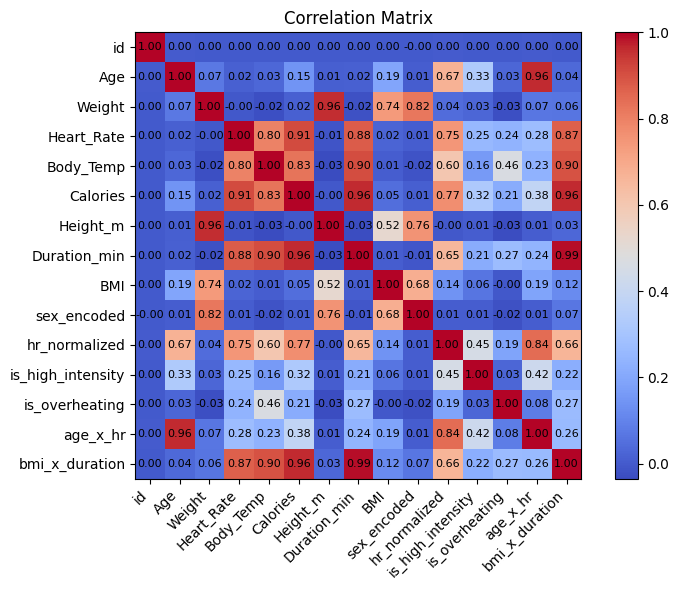

In [8]:
corr_matrix = train.corr()

plt.figure(figsize=(8, 6))
plt.title('Correlation Matrix')
im = plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(im)
plt.xticks(ticks=np.arange(len(corr_matrix.columns)), labels=corr_matrix.columns, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(corr_matrix.index)), labels=corr_matrix.index)
for i in range(len(corr_matrix.index)):
    for j in range(len(corr_matrix.columns)):
        plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='black', fontsize=8)
plt.tight_layout()

MODELLING

In [9]:
from sklearn.model_selection import train_test_split

# Misal target kolom adalah 'Calories'
X = train.drop(columns=['Calories'])
y = train['Calories']

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error

In [24]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
# Definisikan dan fit model-model
model_xgb = XGBRegressor(n_jobs=-1, random_state=42)
model_rf = RandomForestRegressor(n_jobs=-1, random_state=42)
model_lgb = LGBMRegressor(random_state=42)
model_cb = CatBoostRegressor(verbose=0, random_state=42)

# Fit ke data training
model_xgb.fit(X_train.drop(columns=['id']), y_train)
model_rf.fit(X_train.drop(columns=['id']), y_train)
model_lgb.fit(X_train.drop(columns=['id']), y_train)
model_cb.fit(X_train.drop(columns=['id']), y_train)

# Prediksi dari masing-masing model
pred_xgb = model_xgb.predict(X_test.drop(columns=['id']))
pred_rf = model_rf.predict(X_test.drop(columns=['id']))
pred_lgb = model_lgb.predict(X_test.drop(columns=['id']))
pred_cb = model_cb.predict(X_test.drop(columns=['id']))

# Rata-rata prediksi (ensemble)
y_pred_ensemble = np.mean([
    pred_xgb,
    pred_rf,
    pred_lgb,
    pred_cb
], axis=0)

# Pastikan nilai tidak negatif
y_pred_ensemble = np.clip(y_pred_ensemble, a_min=0, a_max=None)

# Hitung RMSLE
rmsle = mean_squared_log_error(y_test, y_pred_ensemble) ** 0.5
print(f"RMSLE Ensemble (Averaging): {rmsle:.5f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1384
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 13
[LightGBM] [Info] Start training from score 88.298465
RMSLE Ensemble (Averaging): 0.06127


In [25]:
# Salin preprocessing dari train ke test
test_processed = test.copy()
test_processed['Height_m'] = test_processed['Height'] / 100
test_processed['Duration_min'] = test_processed['Duration']
test_processed['BMI'] = test_processed['Weight'] / (test_processed['Height_m'] ** 2)
test_processed['sex_encoded'] = test_processed['Sex'].map({'male': 1, 'female': 0})
test_processed['max_hr'] = 220 - test_processed['Age']
test_processed['hr_normalized'] = test_processed['Heart_Rate'] / test_processed['max_hr']
test_processed['is_high_intensity'] = (test_processed['hr_normalized'] > 0.7).astype(int)
test_processed['is_overheating'] = (test_processed['Body_Temp'] > 38).astype(int)
test_processed['age_x_hr'] = test_processed['Age'] * test_processed['Heart_Rate']
test_processed['bmi_x_duration'] = test_processed['BMI'] * test_processed['Duration_min']
test_processed['sex_x_hr'] = test_processed['sex_encoded'] * test_processed['Heart_Rate']

# Drop kolom yang redundant
test_processed.drop(columns=[
    'Height',
    'Duration',
    'Sex',
    'max_hr',
    'sex_x_hr',
], inplace=True)

# Urutkan kolom agar sama dengan X_train (kecuali 'Calories')
cols = [col for col in X_train.columns if col in test_processed.columns]
test_processed = test_processed[cols]

# Prediksi menggunakan ensemble (rata-rata model)
pred_test_xgb = model_xgb.predict(test_processed.drop(columns=['id']))
pred_test_rf = model_rf.predict(test_processed.drop(columns=['id']))
pred_test_lgb = model_lgb.predict(test_processed.drop(columns=['id']))
pred_test_cb = model_cb.predict(test_processed.drop(columns=['id']))

y_pred_test = np.mean([pred_test_xgb, pred_test_rf, pred_test_lgb, pred_test_cb], axis=0)
y_pred_test = np.clip(y_pred_test, a_min=0, a_max=None)

# Buat file submission
submission = pd.DataFrame({
    'id': test_processed['id'],
    'Calories': y_pred_test
})
submission.to_csv('submission.csv', index=False)
submission.head()

,id,Calories
0,750000,27.573351
1,750001,107.685803
2,750002,86.873386
3,750003,126.591474
4,750004,76.071266


In [27]:
test

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8
1,750001,male,26,200.0,97.0,20.0,101.0,40.5
2,750002,female,29,188.0,85.0,16.0,102.0,40.4
3,750003,female,39,172.0,73.0,20.0,107.0,40.6
4,750004,female,30,173.0,67.0,16.0,94.0,40.5
...,...,...,...,...,...,...,...,...
249995,999995,female,56,159.0,62.0,6.0,85.0,39.4
249996,999996,male,32,202.0,101.0,3.0,84.0,38.4
249997,999997,female,31,164.0,64.0,14.0,98.0,40.1
249998,999998,female,62,158.0,61.0,25.0,106.0,40.7


In [26]:
submission

,id,Calories
0,750000,27.573351
1,750001,107.685803
2,750002,86.873386
3,750003,126.591474
4,750004,76.071266
...,...,...
249995,999995,25.948726
249996,999996,9.519274
249997,999997,73.061405
249998,999998,168.077195


In [30]:
train['Calories'].describe()

count    750000.000000
mean         88.282781
std          62.395349
min           1.000000
25%          34.000000
50%          77.000000
75%         136.000000
max         314.000000
Name: Calories, dtype: float64

In [31]:
submission['Calories'].describe()

count    250000.000000
mean         88.244610
std          62.269058
min           0.529231
25%          34.073400
50%          76.416745
75%         135.472093
max         305.864951
Name: Calories, dtype: float64

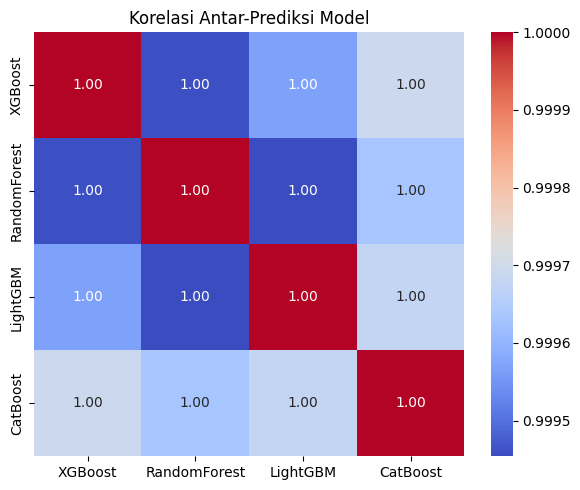

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Gabungkan semua prediksi ke dalam DataFrame
pred_df = pd.DataFrame({
    'XGBoost': pred_xgb,
    'RandomForest': pred_rf,
    'LightGBM': pred_lgb,
    'CatBoost': pred_cb
})

# Hitung korelasi antar prediksi
corr_matrix = pred_df.corr()

# Visualisasikan korelasinya
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelasi Antar-Prediksi Model")
plt.tight_layout()
plt.show()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1383
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 13
[LightGBM] [Info] Start training from score 88.298465
LightGBM RMSLE: 0.07065
RandomForest RMSLE: 0.06272

Ensemble RMSLE (Simple Averaging): 0.06269


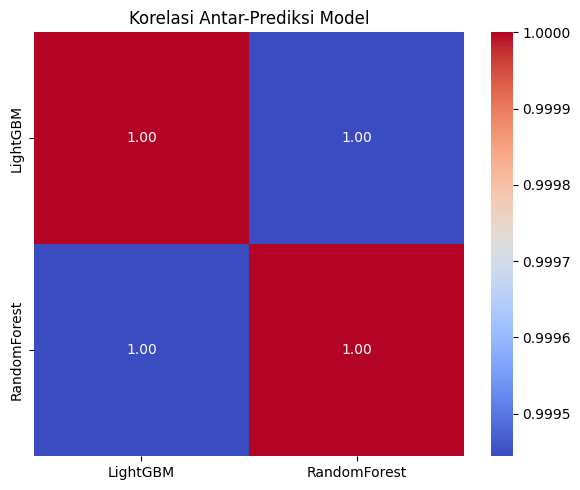

In [38]:
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Inisialisasi model dengan random_state berbeda
models = {
    'LightGBM': LGBMRegressor(random_state=1, n_jobs=-1),
    'RandomForest': RandomForestRegressor(random_state=2, n_jobs=-1),
}

# Menyimpan hasil prediksi dan skor
predictions = {}
results = {}

for name, model in models.items():
    model.fit(X_train.drop(columns=['id']), y_train)
    y_pred = model.predict(X_test.drop(columns=['id']))
    y_pred = y_pred.clip(min=0)
    rmsle = mean_squared_log_error(y_test, y_pred) ** 0.5
    predictions[name] = y_pred
    results[name] = rmsle
    print(f"{name} RMSLE: {rmsle:.5f}")

# Membuat ensemble (simple average)
ensemble_pred = sum(predictions.values()) / len(predictions)
ensemble_rmsle = mean_squared_log_error(y_test, ensemble_pred.clip(min=0)) ** 0.5
print(f"\nEnsemble RMSLE (Simple Averaging): {ensemble_rmsle:.5f}")

# Visualisasi korelasi antar prediksi
pred_df = pd.DataFrame(predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(pred_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelasi Antar-Prediksi Model")
plt.tight_layout()
plt.show()


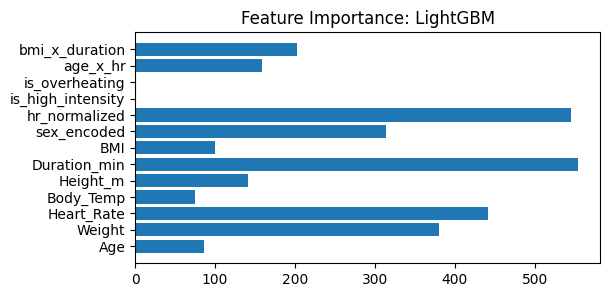

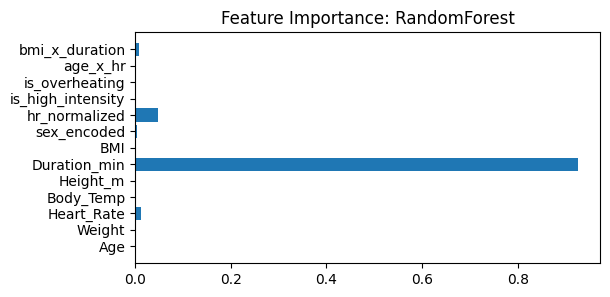

In [39]:
import matplotlib.pyplot as plt

for name, model in models.items():
    if hasattr(model, "feature_importances_"):
        plt.figure(figsize=(6, 3))
        plt.barh(X_train.drop(columns=['id']).columns, model.feature_importances_)
        plt.title(f"Feature Importance: {name}")
        plt.show()


In [40]:
# Standar deviasi antar model per data point
pred_df = pd.DataFrame(predictions)
std_per_row = pred_df.std(axis=1)
print("Rata-rata deviasi antar model per baris:", std_per_row.mean())


Rata-rata deviasi antar model per baris: 0.9730214220254676


In [ ]:
# Gunakan subset data kecil untuk tuning agar lebih cepat
X_tr_small = X_train_small.drop(columns=['id'])
y_tr_small = y_train_small

# RandomizedSearchCV untuk RandomForest pada data kecil
rf_search = RandomizedSearchCV(
    estimator=model_rf,
    param_distributions=param_dist_rf,
    n_iter=10,
    scoring='neg_mean_squared_log_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)
rf_search.fit(X_tr_small, y_tr_small)
print("Best RF params:", rf_search.best_params_)
print("Best RF RMSLE (CV):", (-rf_search.best_score_) ** 0.5)
rf_best = rf_search.best_estimator_

# RandomizedSearchCV untuk LightGBM pada data kecil
lgb_search = RandomizedSearchCV(
    estimator=model_lgb,
    param_distributions=param_dist_lgb,
    n_iter=10,
    scoring='neg_mean_squared_log_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)
lgb_search.fit(X_tr_small, y_tr_small)
print("Best LGB params:", lgb_search.best_params_)
print("Best LGB RMSLE (CV):", (-lgb_search.best_score_) ** 0.5)
lgb_best = lgb_search.best_estimator_

# Prediksi pada test_processed
y_pred_test_rf = rf_best.predict(test_processed.drop(columns=['id']))
y_pred_test_lgb = lgb_best.predict(test_processed.drop(columns=['id']))

# Rata-rata ensemble
y_pred_test_avg = np.mean([y_pred_test_rf, y_pred_test_lgb], axis=0)
y_pred_test_avg = np.clip(y_pred_test_avg, a_min=0, a_max=None)

# Submission
submission_ensemble = pd.DataFrame({
    'id': test_processed['id'],
    'Calories': y_pred_test_avg
})
submission_ensemble.to_csv('submission_ensemble.csv', index=False)
submission_ensemble.head()

Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 